In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from surprise import Dataset, Reader
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

import functions as f

In [2]:
df = pd.read_csv('data/ratings_top.csv')

reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df[['user_id', 'isbn', 'book_rating']], reader)

In [3]:
def get_model_name(model):
    return str(model).split('.')[-1].split(' ')[0].replace("'>","")

def cv_multiple_models(data, models_dict):
    results = pd.DataFrame()

    for model_name, model in models_dict.items():
        print('\n---> CV for %s...' % model_name)

        cv_results = cross_validate(model, data)
        tmp = pd.DataFrame(cv_results).mean()
        tmp['model'] = model_name
        results = results.append(tmp, ignore_index=True)
    
    return results

def generate_models_dict(models, sim_names, user_based):
    models_dict = {}

    for sim_name in sim_names:
        sim_dict = {
            'name': sim_name,
            'user_based': user_based
        }
        for model in models:
            model_name = get_model_name(model) + ' ' + sim_name
            models_dict[model_name] = model(sim_options=sim_dict)
    
    return models_dict

def draw_model_results(results):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    plt.xticks(rotation=90)

    palette = sns.color_palette("RdBu", len(results))

    sns.barplot(x='model', y='test_rmse', data=results, palette=palette, ax=ax1)
    ax1.set_title('Test RMSE and fit time of evaluated models')

    ax2 = ax1.twinx()
    sns.scatterplot(x='model', y='fit_time', data=results, color='black', ax=ax2)
    ax2.set(ylim=(0, results['fit_time'].max() * 1.1))

    plt.show()

## KNN Model Selection

In [57]:
models1 = f.generate_models_dict([KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline], ['cosine'], True)
results1 = f.cv_multiple_models(data, models1)
display(results1)


---> CV for KNNBasic cosine...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.

---> CV for KNNWithMeans cosine...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.

---> CV for KNNWithZScore cosine...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing si

,fit_time,model,test_mae,test_rmse,test_time
0,28.054723,KNNBasic cosine,1.503262,1.938529,2.965623
1,29.163696,KNNWithMeans cosine,1.338067,1.789779,2.950060
2,30.084334,KNNWithZScore cosine,1.321245,1.781945,3.219803
3,26.259329,KNNBaseline cosine,1.347131,1.759631,3.521180


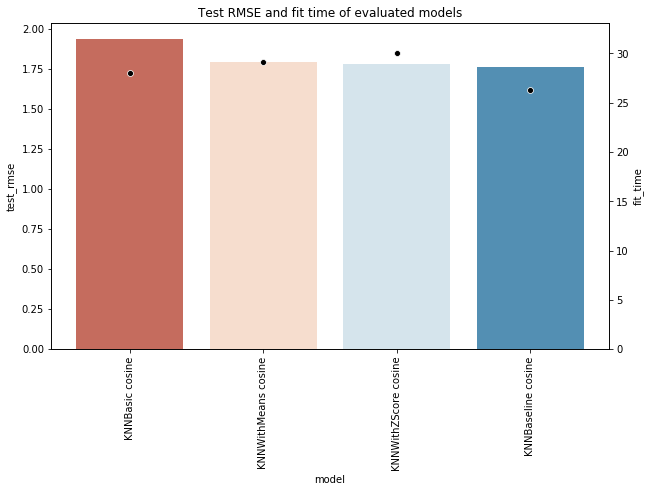

In [66]:
f.draw_model_results(results1)

Which KNN model to choose?

**The best MAE score** KNN with Z score - slightly better than KNN with Means but it takes more time to fit & test this model. It's calculation formula is more complicated thus it's better to choose KNN with Means.

**The best RMSE score** KNN Baseline - the longest fit and test time.

It seems reasonable to choose KNN with Means for further analysis.

## User-based model selection

In [ ]:
models2 = f.generate_models_dict([KNNWithMeans], ['cosine', 'msd', 'pearson'], True)
results2 = f.cv_multiple_models(data, models2)
display(results2)


---> CV for KNNWithMeans cosine...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


## Item-based model selection

In [69]:
models3 = f.generate_models_dict([KNNWithMeans], ['cosine', 'msd', 'pearson'], False)
results3 = f.cv_multiple_models(data, models3)
display(results3)


---> CV for KNNWithMeans cosine...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.

---> CV for KNNWithMeans msd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.

---> CV for KNNWithMeans pearson...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity mat

,fit_time,model,test_mae,test_rmse,test_time
0,13.423908,KNNWithMeans cosine,1.299388,1.725922,3.889338
1,4.591571,KNNWithMeans msd,1.307717,1.739683,3.835427
2,18.467291,KNNWithMeans pearson,1.334679,1.752844,3.480082


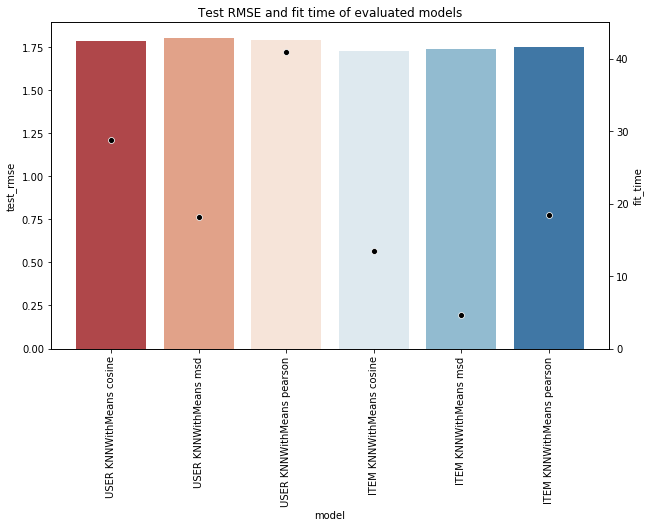

In [78]:
results2['model'] = 'USER ' + results2['model']
results3['model'] = 'ITEM ' + results3['model']

f.draw_model_results(pd.concat([results2, results3]))

## Model optimisation

In [84]:
param_grid = {'k': [20,40],
              'min_k': [1,3]
              'sim_options': {'name': ['msd', 'cosine'],
                              'min_support': [1, 5],
                              'user_based': [False]}
              }
gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

#1.7144841610870258
#{'k': 60, 'min_k': 3, 'sim_options': {'name': 'cosine', 'min_support': 1, 'user_based': False}}

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix.

Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matr

## Analysis of results

In [85]:
def k_from_details(details):
    try:
        return details['actual_k']
    except KeyError:
        return 1000

In [86]:
trainset, testset = train_test_split(data, test_size=0.2)

sim_options = {
    'name': 'cosine',
    'user_based': False
}

model = KNNWithMeans(sim_options=sim_options)
model.fit(trainset)
predictions = model.test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [87]:
df_pred = pd.DataFrame(predictions, columns=['user_id', 'isbn', 'actual_rating', 'pred_rating', 'details'])

df_pred['k'] = df_pred['details'].apply(f.k_from_details)
df_pred['impossible'] = df_pred['details'].apply(lambda x: x['was_impossible'])
df_pred['pred_rating_round'] = df_pred['pred_rating'].round()
df_pred['abs_err'] = abs(df_pred['pred_rating'] - df_pred['actual_rating'])
df_pred.drop(['details'], axis=1, inplace=True)

df_pred.sample(10)

,user_id,isbn,actual_rating,pred_rating,k,impossible,pred_rating_round,abs_err
8776,266775,846630679X,8.0,8.333333,0,False,8.0,0.333333
26029,271176,0441102670,6.0,8.558440,10,False,9.0,2.558440
1741,101620,0385503822,7.0,8.020794,15,False,8.0,1.020794
13467,163534,0099282410,5.0,7.300000,1,False,7.0,2.300000
11063,93047,0393050939,8.0,7.933881,12,False,8.0,0.066119
15308,59656,1558746463,10.0,9.002322,3,False,9.0,0.997678
7150,267837,0385720106,4.0,6.812500,0,False,7.0,2.812500
7879,226006,034538430X,8.0,7.963026,3,False,8.0,0.036974
12042,84024,0446609617,5.0,8.111002,4,False,8.0,3.111002
7602,55548,0679445358,8.0,8.872647,1,False,9.0,0.872647


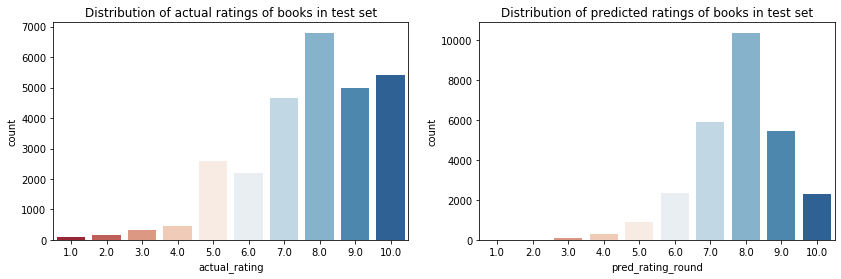

In [88]:
palette = sns.color_palette("RdBu", 10)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

sns.countplot(x='actual_rating', data=df_pred, palette=palette, ax=ax1)
ax1.set_title('Distribution of actual ratings of books in test set')

sns.countplot(x='pred_rating_round', data=df_pred, palette=palette, ax=ax2)
ax2.set_title('Distribution of predicted ratings of books in test set')

plt.show()

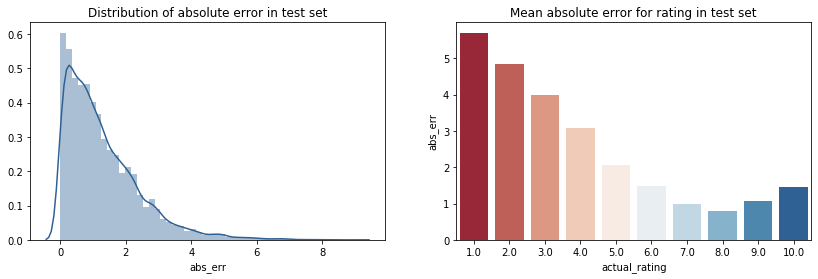

In [89]:
df_pred_err = df_pred.groupby('actual_rating')['abs_err'].mean().reset_index()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

sns.distplot(df_pred['abs_err'], color='#2f6194', ax=ax1)
ax1.set_title('Distribution of absolute error in test set')

sns.barplot(x='actual_rating', y='abs_err', data=df_pred_err, palette=palette, ax=ax2)
ax2.set_title('Mean absolute error for rating in test set')

plt.show()

In [97]:
df_books = pd.read_csv('data/books.csv')

df_pred_ext = df_pred.merge(df_books[['isbn', 'book_title']], on='isbn', how='left')
df_pred_ext['book_title_short'] = df_pred_ext['book_title'].apply(f.short_title)
df_pred_ext.head()

#df = df.merge(df_pred, left_on=['isbn', 'user_id'], right_on=['iid', 'uid'], how='left')
#df.drop(['uid', 'iid', 'rui'], axis=1, inplace=True)

,user_id,isbn,actual_rating,pred_rating,k,impossible,pred_rating_round,abs_err,book_title,book_title_short
0,249862,0671793489,10.0,8.690539,21,False,9.0,1.309461,All Around the Town,All Around the Town
1,102647,0515109509,8.0,6.693678,9,False,7.0,1.306322,The Cat Who Moved a Mountain,The Cat Who Moved a Mountain
2,191795,0765340747,9.0,7.764836,1000,True,8.0,1.235164,"The Pillars of Creation (Sword of Truth, Book 7)","The Pillars of Creation (Sword of Truth,"
3,47465,0446611867,10.0,7.116393,2,False,7.0,2.883607,A Bend in the Road,A Bend in the Road
4,97493,0316602051,10.0,6.848680,2,False,7.0,3.151320,The Jester,The Jester


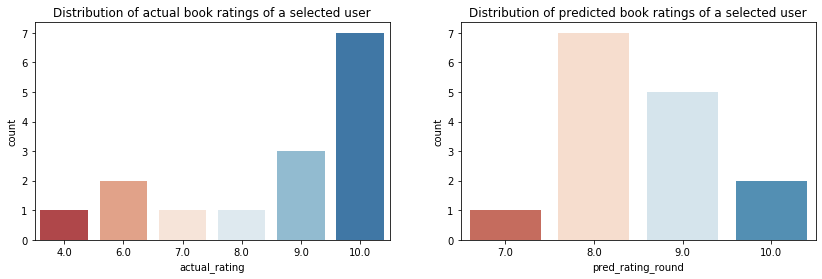

In [101]:
# Selected user: 246311
selected_user_id = 246311

df_pred_user = df_pred_ext[df_pred_ext['user_id']==selected_user_id]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

sns.countplot(x='actual_rating', data=df_pred_user, palette=sns.color_palette("RdBu", len(df_pred_user['actual_rating'].unique())), ax=ax1)
ax1.set_title('Distribution of actual book ratings of a selected user')

sns.countplot(x='pred_rating_round', data=df_pred_user, palette=sns.color_palette("RdBu", len(df_pred_user['pred_rating_round'].unique())), ax=ax2)
ax2.set_title('Distribution of predicted book ratings of a selected user')

plt.show()

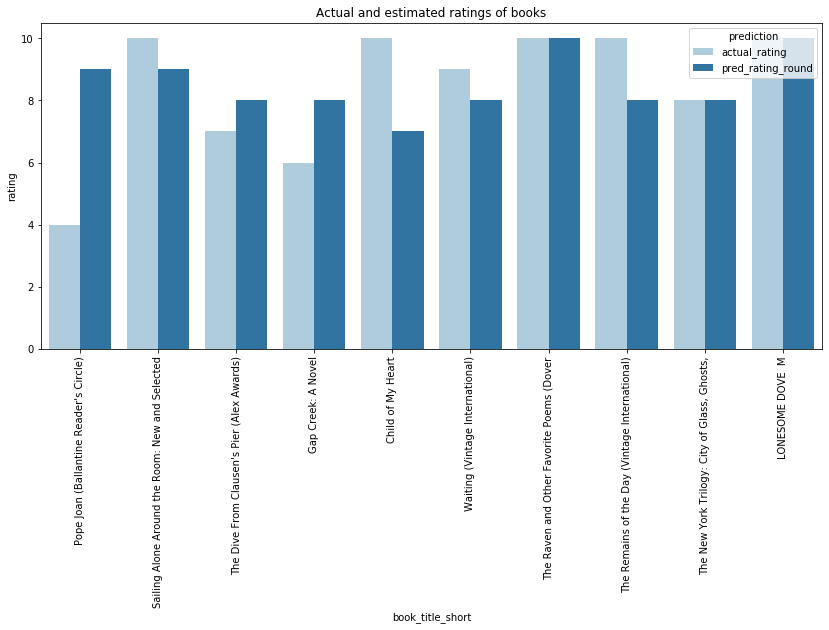

In [112]:
df_pred_sample = df_pred_user[df_pred_user['pred_rating_round'].notna()].sample(10)
df_pred_sample = pd.melt(df_pred_sample[['book_title_short', 'actual_rating', 'pred_rating_round']], id_vars='book_title_short', var_name='prediction', value_name='rating')

fig, ax = plt.subplots(figsize=(14, 6))

sns.barplot(x='book_title_short', y='rating', hue='prediction', data=df_pred_sample, palette=sns.color_palette("Paired"))
ax.set_title('Actual and estimated ratings of books')
plt.xticks(rotation=90)

plt.show()